<a href="https://colab.research.google.com/github/CarlosMendez1997Col/Automation_of_satellite_image_downloads_GeeMap_APIs_REST/blob/main/1.%20Sentinel/Sentinel1_ASF_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# `Automated script to download Sentinel-1 images using Alaska Satellite Facility API`


# Import libraries and packages

In [15]:
!apt-get install -y gdal-bin python3-gdal # Install GDAL system packages for geospatial data handling
!pip install asf_search # Install ASF Search library to query Sentinel-1 data from Alaska Satellite Facility
!pip install shapely # Install Shapely for geometric operations (bounding boxes, polygons)
!pip install rasterio # Install Rasterio for raster data reading/writing
!pip install rioxarray # Install Rioxarray for raster data handling with xarray

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
gdal-bin is already the newest version (3.8.4+dfsg-1~jammy0).
python3-gdal is already the newest version (3.8.4+dfsg-1~jammy0).
0 upgraded, 0 newly installed, 0 to remove and 2 not upgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 30.3 MB/s eta 0:00:00
  Attempting uninstall: xarray
    Found existing installation: xarray 2025.12.0
    Uninstalling xarray-2025.12.0:
      Successfully uninstalled xarray-2025.12.0


In [16]:
import asf_search as asf # Import ASF search library
from shapely.geometry import box, mapping # Import Shapely geometry tools to build bounding boxes and convert to WKT
from datetime import datetime, timezone # Import datetime utilities for defining search date ranges

# Import standard libraries for file handling and compression
import os
import zipfile
import geopandas as gpd
import rioxarray

# Import rasterio for raster processing
import rasterio
import rasterio.mask

from google.colab import files # Import Colab utility to download files to local machine
import getpass # Import getpass for secure password input
import pyproj # Import pyproj for coordinate transformations
from shapely.ops import transform # Import Shapely transform for reprojection
import numpy as np # Import numpy for numerical operations
from rasterio import shutil as rio_shutil # Import rasterio shutil for file operations
from scipy.ndimage import uniform_filter # Import uniform_filter for local statistics (used in Lee filter)
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

# Authenticate with Earthdata NASA

In [3]:
# --- Prompt for Earthdata credentials securely ---
username = input("Enter your Earthdata username: ")
password = getpass.getpass("Enter your Earthdata password: ")

# --- Authenticate with Earthdata credentials ---
session = asf.ASFSession().auth_with_creds(username, password)

Enter your Earthdata username: Carlosmendez1997
Enter your Earthdata password: ··········


# Define Area of Interest (AOI)

In [4]:
# --- Subir shapefile ---
uploaded = files.upload()  # selecciona .shp, .shx, .dbf, .prj

# --- Leer shapefile y reproyectar ---
shp_path = "/content/CobijaAOI.shp"
gdf = gpd.read_file(shp_path).to_crs(epsg=4326)

# --- Calcular bounding box ---
xmin, ymin, xmax, ymax = gdf.total_bounds
bbox_geom = box(xmin, ymin, xmax, ymax)
wkt_geom = bbox_geom.wkt

Saving CobijaAOI.CPG to CobijaAOI.CPG
Saving CobijaAOI.dbf to CobijaAOI.dbf
Saving CobijaAOI.prj to CobijaAOI.prj
Saving CobijaAOI.sbn to CobijaAOI.sbn
Saving CobijaAOI.sbx to CobijaAOI.sbx
Saving CobijaAOI.shp to CobijaAOI.shp
Saving CobijaAOI.shx to CobijaAOI.shx


# Define search parameters

In [5]:
# --- Define search parameters for Sentinel-1 ---
platform = "Sentinel-1A"          # Satellite platform
polarizations = ["VV", "VH"]      # Polarizations to include
beam_mode = "IW"                  # Interferometric Wide swath mode
processing_level = "GRD"          # Ground Range Detected products
orbit_direction = "DESCENDING"    # Orbit direction filter
relative_orbit = 127              # Relative orbit number

# Set date range

In [6]:
# --- Date range for search ---
start_date = "2026-01-01" # Start date
end_date = datetime.now(timezone.utc).strftime("%Y-%m-%d") # Current date

# Perform Search on ASF

In [7]:
# --- Perform search on ASF ---
results = asf.search(
    platform=platform,
    processingLevel=processing_level,
    beamMode=beam_mode,
    polarization=polarizations,
    relativeOrbit=relative_orbit,
    start=start_date,
    end=end_date,
    intersectsWith=wkt_geom
)

# --- Print number of scenes found ---
print(f"Found {len(results)} Sentinel-1 scenes")

Found 32 Sentinel-1 scenes


# Create folder to dowload data

In [9]:
# --- Create folder for downloads ---
os.makedirs("ASF_Sentinel1", exist_ok=True)
# --- Download results into folder ---
results.download(path="ASF_Sentinel1", session=session)

# Create output folder for GeoTIFFs

In [10]:
# --- Create output folder for processed GeoTIFFs ---
output_dir = "ASF_Sentinel1/GeoTIFFs"
os.makedirs(output_dir, exist_ok=True)

# Additional processing S1 images

## Lee speckle filter

In [17]:
# --- Lee Speckle Filter con rioxarray ---
def lee_filter_riox(src_path, out_path, size=7):
    xds = rioxarray.open_rasterio(src_path)
    band = xds.values[0]
    if np.iscomplexobj(band):
        band = np.abs(band)
    band = band.astype(np.float32)
    mean = uniform_filter(band, size=size)
    mean_sq = uniform_filter(band**2, size=size)
    variance = mean_sq - mean**2
    overall_variance = np.var(band)
    weight = variance / (variance + overall_variance)
    filtered = mean + weight * (band - mean)
    # Reemplazar valores en el DataArray
    xds.values[0] = filtered
    # Guardar preservando CRS
    xds.rio.to_raster(out_path)
    print(f"Saved Lee-filtered raster with CRS preserved: {out_path}")

## Process downloaded .tiff files

In [18]:
# --- Process downloaded files ---
for root, dirs, files_in_dir in os.walk("ASF_Sentinel1"):
    for f in files_in_dir:
        if f.endswith(".tiff") and ("VV" in f or "VH" in f):
            src_path = os.path.join(root, f)
            try:
                date_str = f.split("_")[3][:8]
            except Exception:
                date_str = "unknown"
            pol = "VV" if "VV" in f else "VH"
            out_name = f"S1_{pol}_{date_str}.tif"
            out_path = os.path.join(output_dir, out_name)
            # Copiar raster con CRS preservado
            xds = rioxarray.open_rasterio(src_path)
            if np.iscomplexobj(xds.values[0]):
                xds.values[0] = np.abs(xds.values[0]).astype(np.float32)
            xds = xds.astype(np.float32)
            xds.rio.to_raster(out_path)
            print(f"Saved raster with CRS preserved: {out_path}")
            # Aplicar filtro Lee
            lee_path = out_path.replace(".tif", "_lee.tif")
            lee_filter_riox(out_path, lee_path)

Saved raster with CRS preserved: ASF_Sentinel1/GeoTIFFs/S1_VH_20260108.tif


Saved Lee-filtered raster with CRS preserved: ASF_Sentinel1/GeoTIFFs/S1_VH_20260108_lee.tif


Saved raster with CRS preserved: ASF_Sentinel1/GeoTIFFs/S1_VV_20260207.tif


Saved Lee-filtered raster with CRS preserved: ASF_Sentinel1/GeoTIFFs/S1_VV_20260207_lee.tif


Saved raster with CRS preserved: ASF_Sentinel1/GeoTIFFs/S1_VV_20260102.tif


Saved Lee-filtered raster with CRS preserved: ASF_Sentinel1/GeoTIFFs/S1_VV_20260102_lee.tif


Saved raster with CRS preserved: ASF_Sentinel1/GeoTIFFs/S1_VH_20260108.tif


Saved Lee-filtered raster with CRS preserved: ASF_Sentinel1/GeoTIFFs/S1_VH_20260108_lee.tif


Saved raster with CRS preserved: ASF_Sentinel1/GeoTIFFs/S1_VH_20260102.tif


Saved Lee-filtered raster with CRS preserved: ASF_Sentinel1/GeoTIFFs/S1_VH_20260102_lee.tif


Saved raster with CRS preserved: ASF_Sentinel1/GeoTIFFs/S1_VH_20260126.tif


Saved Lee-filtered raster with CRS preserved: ASF_Sentinel1/GeoTIFFs/S1_VH_20260126_lee.tif


Saved raster with CRS preserved: ASF_Sentinel1/GeoTIFFs/S1_VH_20260207.tif


Saved Lee-filtered raster with CRS preserved: ASF_Sentinel1/GeoTIFFs/S1_VH_20260207_lee.tif


Saved raster with CRS preserved: ASF_Sentinel1/GeoTIFFs/S1_VH_20260207.tif


Saved Lee-filtered raster with CRS preserved: ASF_Sentinel1/GeoTIFFs/S1_VH_20260207_lee.tif


Saved raster with CRS preserved: ASF_Sentinel1/GeoTIFFs/S1_VV_20260108.tif


Saved Lee-filtered raster with CRS preserved: ASF_Sentinel1/GeoTIFFs/S1_VV_20260108_lee.tif


Saved raster with CRS preserved: ASF_Sentinel1/GeoTIFFs/S1_VV_20260126.tif


Saved Lee-filtered raster with CRS preserved: ASF_Sentinel1/GeoTIFFs/S1_VV_20260126_lee.tif


Saved raster with CRS preserved: ASF_Sentinel1/GeoTIFFs/S1_VV_20260102.tif


Saved Lee-filtered raster with CRS preserved: ASF_Sentinel1/GeoTIFFs/S1_VV_20260102_lee.tif


Saved raster with CRS preserved: ASF_Sentinel1/GeoTIFFs/S1_VH_20260126.tif


Saved Lee-filtered raster with CRS preserved: ASF_Sentinel1/GeoTIFFs/S1_VH_20260126_lee.tif


Saved raster with CRS preserved: ASF_Sentinel1/GeoTIFFs/S1_VH_20260102.tif


Saved Lee-filtered raster with CRS preserved: ASF_Sentinel1/GeoTIFFs/S1_VH_20260102_lee.tif


Saved raster with CRS preserved: ASF_Sentinel1/GeoTIFFs/S1_VV_20260207.tif


Saved Lee-filtered raster with CRS preserved: ASF_Sentinel1/GeoTIFFs/S1_VV_20260207_lee.tif


Saved raster with CRS preserved: ASF_Sentinel1/GeoTIFFs/S1_VV_20260108.tif


Saved Lee-filtered raster with CRS preserved: ASF_Sentinel1/GeoTIFFs/S1_VV_20260108_lee.tif


Saved raster with CRS preserved: ASF_Sentinel1/GeoTIFFs/S1_VV_20260126.tif


Saved Lee-filtered raster with CRS preserved: ASF_Sentinel1/GeoTIFFs/S1_VV_20260126_lee.tif


In [20]:
# --- Comparación simplificada ---
def compare_rasters(original_path, filtered_path, title="Comparación"):
    xds_orig = rioxarray.open_rasterio(original_path)
    xds_filt = rioxarray.open_rasterio(filtered_path)
    print(f"{title}: Original CRS={xds_orig.rio.crs}, Filtrado CRS={xds_filt.rio.crs}")

for file in os.listdir(output_dir):
    if file.endswith(".tif") and not file.endswith("_lee.tif"):
        original_path = os.path.join(output_dir, file)
        filtered_path = original_path.replace(".tif", "_lee.tif")
        if os.path.exists(filtered_path):
            compare_rasters(original_path, filtered_path, title=file)

# --- Verificación final de CRS ---
print("\nResumen de CRS en archivos exportados:")
for file in os.listdir(output_dir):
    if file.endswith(".tif"):
        file_path = os.path.join(output_dir, file)
        xds = rioxarray.open_rasterio(file_path)
        print(f"{file} → CRS: {xds.rio.crs}")

S1_VV_20260126.tif: Original CRS=EPSG:4326, Filtrado CRS=EPSG:4326
S1_VV_20260207.tif: Original CRS=EPSG:4326, Filtrado CRS=EPSG:4326
S1_VV_20260102.tif: Original CRS=EPSG:4326, Filtrado CRS=EPSG:4326
S1_VH_20260102.tif: Original CRS=EPSG:4326, Filtrado CRS=EPSG:4326
S1_VV_20260108.tif: Original CRS=EPSG:4326, Filtrado CRS=EPSG:4326
S1_VH_20260126.tif: Original CRS=EPSG:4326, Filtrado CRS=EPSG:4326
S1_VH_20260108.tif: Original CRS=EPSG:4326, Filtrado CRS=EPSG:4326
S1_VH_20260207.tif: Original CRS=EPSG:4326, Filtrado CRS=EPSG:4326

Resumen de CRS en archivos exportados:
S1_VH_20260108_lee.tif → CRS: EPSG:4326
S1_VV_20260102_lee.tif → CRS: EPSG:4326
S1_VV_20260108_lee.tif → CRS: EPSG:4326
S1_VV_20260126.tif → CRS: EPSG:4326
S1_VV_20260207.tif → CRS: EPSG:4326
S1_VV_20260102.tif → CRS: EPSG:4326
S1_VH_20260102.tif → CRS: EPSG:4326
S1_VH_20260207_lee.tif → CRS: EPSG:4326
S1_VH_20260126_lee.tif → CRS: EPSG:4326
S1_VV_20260108.tif → CRS: EPSG:4326
S1_VV_20260126_lee.tif → CRS: EPSG:4326
S1_V

# Compress all GeoTIFFs into a single ZIP

In [27]:
# --- Compress all GeoTIFFs into a single ZIP ---
zip_path = "ASF_Sentinel1/Sentinel1_GeoTIFFs.zip"
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for file in os.listdir(output_dir):
        file_path = os.path.join(output_dir, file)
        zipf.write(file_path, arcname=file)

print(f"Compressed file ready: {zip_path}")

Compressed file ready: ASF_Sentinel1/Sentinel1_GeoTIFFs.zip


# Download ZIP to local machine

In [28]:
# --- Download ZIP to local machine ---
files.download(zip_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# --- Visualización comparativa automática ---

TypeError: Image data of dtype complex64 cannot be converted to float

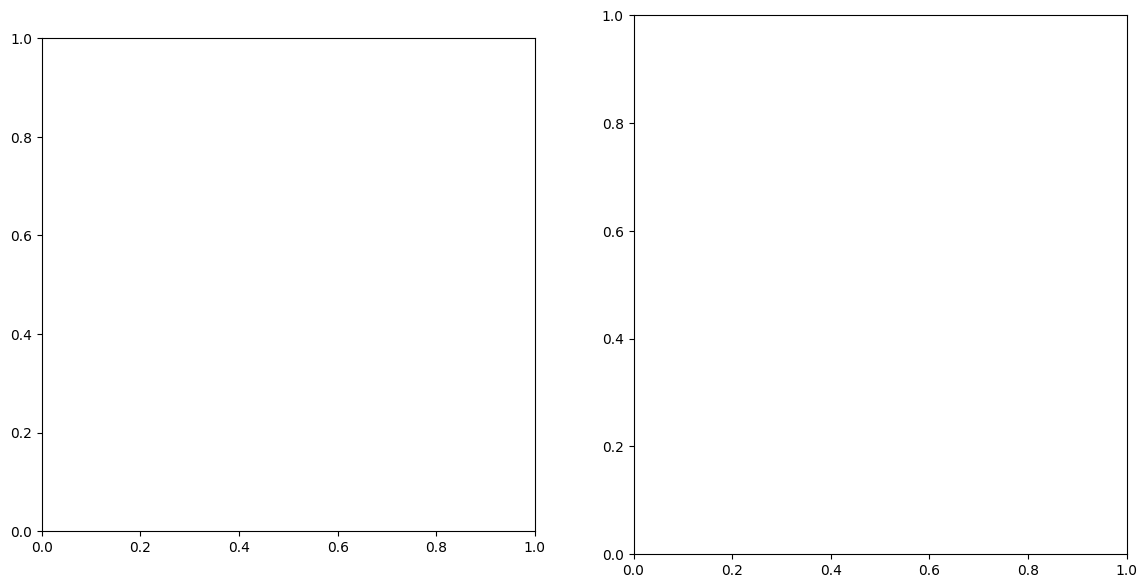

In [29]:
# --- Visualización comparativa automática ---
import matplotlib.pyplot as plt

def compare_rasters(original_path, filtered_path, title="Comparación"):
    with rasterio.open(original_path) as src:
        band_orig = src.read(1)
    with rasterio.open(filtered_path) as src:
        band_filt = src.read(1)
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))
    axes[0].imshow(band_orig, cmap="gray")
    axes[0].set_title("Original")
    axes[0].axis("off")
    axes[1].imshow(band_filt, cmap="gray")
    axes[1].set_title("Lee Filter")
    axes[1].axis("off")
    plt.suptitle(title, fontsize=16)
    plt.show()

# Recorrer todos los archivos y mostrar comparaciones
for file in os.listdir(output_dir):
    if file.endswith(".tif") and not file.endswith("_lee.tif"):
        original_path = os.path.join(output_dir, file)
        filtered_path = original_path.replace(".tif", "_lee.tif")
        if os.path.exists(filtered_path):
            compare_rasters(original_path, filtered_path, title=file)
